In [1]:
import fenics as fe
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# Parameters
# --------------------

# Density
rho = fe.Constant(7850.0)  # kg /m^3

# Young's modulus and Poisson's ratio
# Steel material
E = 200e9  # Pa
nu = 0.3

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

l_x, l_y = 0.10, 0.05  # Domain dimensions (m)

# Displacement
d_x = 0.01

# Load
g_z = 2.9575e10
b_z = 0.0
g = fe.Constant((g_z, 0.0))
b = fe.Constant((0.0, b_z))

# --------------------
# Functions and classes
# --------------------
# Bottom top boundary
def bottom_top(x, on_boundary):
    return (on_boundary and (fe.near(x[1], 0.0) or fe.near(x[1], l_y)))

def left(x, on_boundary):
    return (on_boundary and fe.near(x[0], 0.0))

def right(x, on_boundary):
    return (on_boundary and fe.near(x[0], l_x))

# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))

model = "plane_strain"

if model == "plane_stress":
    lambda_ = 2*mu*lambda_/(lambda_+2*mu)

# Stress function
def sigma(u):
    return lambda_*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)
# lambda is a reserved python keyword, naming convention recommends using a single trailing underscore for such cases

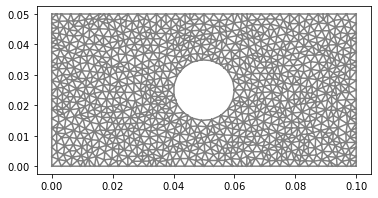

In [2]:
# --------------------
# Geometry
# --------------------
domain = Rectangle(dolfin.Point(0., 0.), dolfin.Point(l_x, l_y)) \
         - Circle(dolfin.Point(l_x / 2.0, l_y / 2.0), l_y / 5.0)
mesh = generate_mesh(domain, 30)

fe.plot(mesh)
plt.show()

In [3]:
# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

In [4]:
# --------------------
# Boundary conditions
# --------------------
bc1 = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), left)
bc2 = fe.DirichletBC(V, fe.Constant((d_x, 0.0)), right)

#right = fe.AutoSubDomain(lambda x: fe.near(x[0], l_x))

# Definition of Neumann boundary condition domain
#boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
#boundaries.set_all(0)
#right.mark(boundaries, 1)
#ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = rho*fe.dot(b, u_test)*fe.dx # + fe.inner(g, u_test)*ds(1)

In [5]:
# --------------------
# Solver
# --------------------
u = fe.Function(V)
A, L = fe.assemble_system(a, l, [bc1, bc2])

In [6]:
problem = fe.LinearVariationalProblem(a,l,u, [bc1, bc2])
solver = fe.LinearVariationalSolver(problem)

fe.solve(A, u.vector(), L)

1

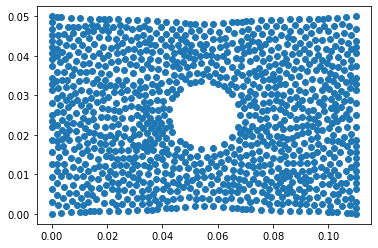

In [84]:
plt.scatter(X[0] + U[0], X[1] + U[1])

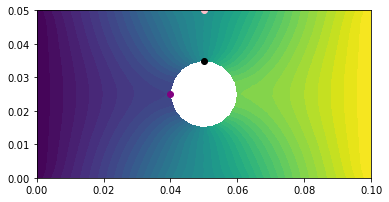

In [73]:
fe.plot(u.sub(0))
plt.scatter(0.05, 0.035, c='black')
plt.scatter(0.05, 0.05, c='pink')
plt.scatter(0.04, 0.025, c='purple')
plt.show()

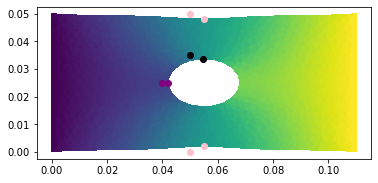

In [76]:
fe.plot(u, mode="displacement")
plt.scatter(0.05, 0.035, c='black')
plt.scatter(0.05 + 0.004767, 0.035 - 0.001340 , c='black')

plt.scatter(0.05, 0.05, c='pink')
plt.scatter(0.05 + 0.0049985739, 0.05 - 0.0019642893 , c='pink')

plt.scatter(0.04, 0.025, c='purple')
plt.scatter(0.04 + 0.001992, 0.025 - 0.0000349, c='purple')

plt.scatter(0.05, 0.0, c='pink')
plt.scatter(0.05 + 0.0049985739, 0.0 + 0.00197 , c='pink')

plt.show()

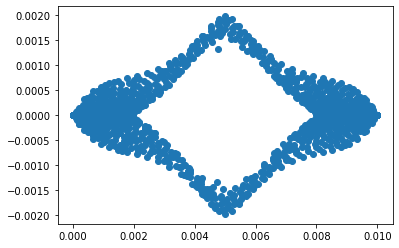

In [78]:
vals = u.compute_vertex_values().reshape(2, -1).T

plt.scatter(vals[:, 0], vals[:, 1])

In [1]:
stress = sigma(u)

s = sigma(u) - (1./3)*fe.tr(sigma(u))*fe.Identity(2)
von_Mises = fe.sqrt(3./2*fe.inner(s, s))

fe.plot(von_Mises)
plt.show()

NameError: name 'sigma' is not defined

In [58]:
V = fe.FunctionSpace(mesh, 'P', 1)
p_von_Mises = fe.project(von_Mises, V)

In [20]:
print(np.argmax(p_von_Mises.compute_vertex_values()))
print(np.min(p_von_Mises.compute_vertex_values()))

10
4781811646.56231


In [19]:
p_von_Mises.compute_vertex_values().shape

(1090,)

In [24]:
V.tabulate_dof_coordinates()[10]

array([0.1    , 0.00625])

In [27]:
dofmap = V.dofmap()
dofs = dofmap.dofs()

In [33]:
dofs_x = V.tabulate_dof_coordinates().reshape((-1, 2))

In [35]:
import matplotlib.pyplot as plt

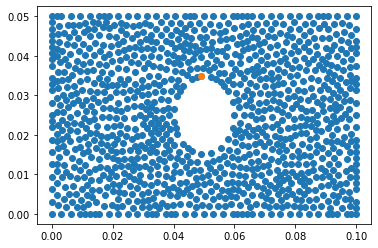

In [42]:
plt.scatter(dofs_x[:,0], dofs_x[:, 1])
plt.scatter(dofs_x[575, 0], dofs_x[575, 1])

In [45]:
np.argmin(np.linalg.norm(dofs_x - np.array([0.05, 0.01]), axis=-1))

442

In [91]:
def stress_at(point):
    dofs_x = V.tabulate_dof_coordinates().reshape((-1, 2))
    ind = np.argmin(np.linalg.norm(dofs_x - point, axis=-1))
    return p_von_Mises.compute_vertex_values().reshape((-1, 2))[ind]

w0 = u.compute_vertex_values(mesh)
nv = mesh.num_vertices()

X = mesh.coordinates()
X = [X[:, i] for i in range(2)]
X = np.stack(X, axis=-1)
U = [w0[i * nv: (i + 1) * nv] for i in range(2)]
U = np.stack(U, axis=-1)

def deformation_at(point):
    ind = np.argmin(np.linalg.norm(X - point, axis=-1))
    return U[ind]

def ref_at(point):
    ind = np.argmin(np.linalg.norm(X - point, axis=-1))
    return X[ind]

In [92]:
ref_at(np.array([0.05, 0.035])) * 100

array([4.91742065, 3.49658449])

In [89]:
print(deformation_at(np.array([0.05, 0.035])) * 100)
print(deformation_at(np.array([0.05, 0.05])) * 100)
print(deformation_at(np.array([0.05, 0.0])) * 100)
print(deformation_at(np.array([0.04, 0.025])) * 100)

[ 0.47217662 -0.133563  ]
[ 0.499965   -0.19723613]
[0.50032498 0.19732047]
[0.19815114 0.00057059]


In [90]:
print(np.linalg.norm(deformation_at(np.array([0.05, 0.035])) * 100))
print(np.linalg.norm(deformation_at(np.array([0.05, 0.05])) * 100))
print(np.linalg.norm(deformation_at(np.array([0.05, 0.0])) * 100))
print(np.linalg.norm(deformation_at(np.array([0.04, 0.025])) * 100))

0.4907034087612863
0.5374635706593368
0.5378293918730558
0.19815196592852408
